Bike sharing linear regression
---

Exercise - Load train/test sets & remove collinear features
---

> **Exercise**: Load the train/test sets into the `X_tr`, `y_tr`, `X_te` and `y_te` variables. Remove features that make the `X_tr` matrix, with the additional column of ones, rank deficient. Also, you might want to remove nearly collinear features if they hurt performance.

**Self-assessment**: Verify that the `X_tr` matrix with the additional column of ones has full rank. Compute its condition number.

In [64]:
import pandas as pd
import numpy as np

# Load data sets
train_df = pd.read_csv("data/bike-train.csv")
test_df = pd.read_csv("data/bike-test.csv")

# remove collinear variables
train_df = train_df.drop(['temp_C', 'atemp_C', 'atemp'], axis=1)
test_df = test_df.drop(['temp_C', 'atemp_C', 'atemp'], axis=1)

# Extract X/y Numpy variables
X_tr = train_df.drop('casual', axis=1).values
y_tr = train_df.casual.values

X_te = test_df.drop('casual', axis=1).values
y_te = test_df.casual.values

In [65]:
# Verify that X_tr with the additional column of ones has full rank
# Add a column of ones
X1_tr = np.c_[np.ones(X_tr.shape[0]), X_tr]

rank = np.linalg.matrix_rank(X1_tr)
print('Rank:', rank)
print(X1_tr.shape)

# Compute its condition number
cn = np.linalg.cond(X1_tr)
print('Condition number:', cn) 

Rank: 7
(365, 7)
Condition number: 22.000828462946874


Exercise - Fit a linear regression model
---

> **Exercise**: (A) Fit a linear regression model to the `X_tr`, `y_tr` variables. Evaluate its performance on the test set using the mean absolute error (MAE). (B) Also, try fitting a linear regression with the Huber loss. (C) Pick one feature (e.g., temperatures) and plot the predictions from your best model (e.g., temperature vs. casual users plot).

**Note**: Your models might predict a negative number of users. In this case, you might want to set a lower limit with the Numpy `maximum()` function to improve performance, e.g. `y_pred = np.maximum(y_pred, 50)`.

In [66]:
# Compare models with mean absolute error (MAE)
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [71]:
# (A) Fit and evaluate a linear regression model
from sklearn.linear_model import LinearRegression

# Create a linear regression object
lr = LinearRegression()
lr.fit(X_tr, y_tr)
y_pred_lr = np.maximum(lr.predict(X_te), 50)# Predictions for test data ,# Set a lower limit
mae_lr = MAE(y_te, y_pred_lr)
print('MAE linear regression: {:.3f}'.format(mae_lr))

MAE linear regression: 279.880


In [74]:
# (B) Same with Huber loss
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(epsilon=1.45)
huber.fit(X_tr, y_tr)
y_pred_huber = np.maximum(huber.predict(X_te), 50)
mae_huber = MAE(y_te, y_pred_huber)
print('MAE HuberRegressor: {:.3f}'.format(mae_huber))

MAE HuberRegressor: 272.904


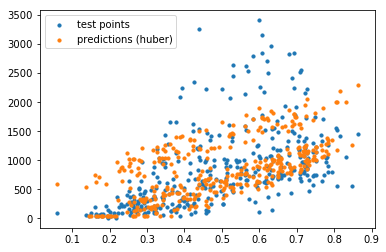

In [78]:
# (C) Plot best model
%matplotlib inline
import matplotlib.pyplot as plt

#Extracting temperatures values
temp_te = X_te[:,0] # temperature column

plt.scatter(temp_te, y_te, s = 10, label='test points')
plt.scatter(temp_te, y_pred_huber, s=10, label = 'predictions (huber)')
plt.legend()
plt.show()

Exercise - Separate sources and fit two linear regressions
---

We saw in the course that we can identify two sources in the data.

1. Data points collected during working days
1. Data points collected during non-working days

The goal of this exercise is to create a model for each source and see whether this improves performance.

> **Exercise**: Create a model for each source and evaluate the overall performance on the test set using MAE. Compare your models to a baseline using a bar chart.

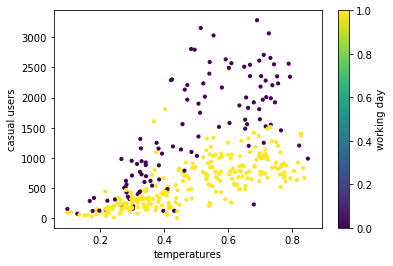

In [81]:
temp_tr = X_tr[:, 0] # 0: temp column
wd_tr = X_tr[:, 4] # 4: workingday column

plt.scatter(temp_tr, y_tr, c=wd_tr, s=10)
plt.colorbar(label='working day')
plt.xlabel('temperatures')
plt.ylabel('casual users')
plt.show()

In [94]:
# Separate data points from the two sources
wd_tr = train_df[train_df["workingday"] == 1].drop(["workingday", "casual"], axis=1).values
wd_te = test_df[test_df["workingday"] == 1].drop(["workingday", "casual"], axis=1).values

y_wd_tr = train_df[train_df["workingday"] == 1].casual.values
y_wd_te = test_df[test_df["workingday"] == 1].casual.values

nwd_tr = train_df[train_df["workingday"] == 0].drop(["workingday", "casual"], axis=1).values
nwd_te = test_df[test_df["workingday"] == 0].drop(["workingday", "casual"], axis=1).values

y_nwd_tr = train_df[train_df["workingday"] == 0].casual
y_nwd_te = test_df[test_df["workingday"] == 0].casual

In [95]:
# Create a model for each one

# Working days
lr_wd = LinearRegression()
lr_wd.fit(wd_tr, y_wd_tr)
y_pred_lr_wd = np.maximum(lr_wd.predict(wd_te), 50)

# Non working days
lr_nwd = LinearRegression()
lr_nwd.fit(nwd_tr, y_nwd_tr)
y_pred_lr_nwd = np.maximum(lr_nwd.predict(nwd_te), 50)

# Reassemble test data and predictions
# target values
y_te_wdnwd = np.concatenate((y_wd_te, y_nwd_te))

# predictions
y_pred_lr_wdnwd = np.concatenate((y_pred_lr_wd, y_pred_lr_nwd))

MAE non working days Huber: 246.269


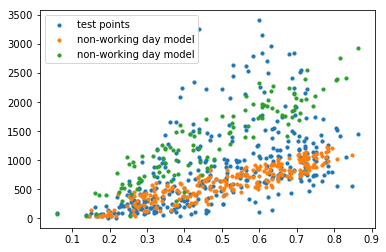

In [103]:
# Evaluate the overall performance using MAE
mae_lr_wdnwd = MAE(y_te_wdnwd, y_pred_lr_wdnwd)
print('MAE non working days Huber: {:.3f}'.format(mae_lr_wdnwd))

# Plot temperatures for workin days and non-working days
temp_te_wdnwd = np.concatenate((wd_te[:,0], nwd_te[:,0]))
plt.scatter(temp_te_wdnwd, y_te_wdnwd, s=10, label='test points')

# Prediction for working days
plt.scatter(wd_te[:,0], y_pred_lr_wd, s=10, label='non-working day model')

# Prediction for non-working days
plt.scatter(nwd_te[:,0], y_pred_lr_nwd, s=10, label='non-working day model')

plt.legend()
plt.show()

In [105]:
# Compare your models to a baseline using a bar chart

# create baseline
mae_baseline = MAE(y_te, np.median(y_tr))
# Bar plot
mae_values = [mae_baseline, mae_lr_huber, mae_lr, mae_lr_wdnwd]
titles =  ['median', 'lr', 'huber', 'lr two models']

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)

plt.ylabel('MAE')
plt.show()

NameError: name 'mae_lr_huber' is not defined

Exercise - R^2 coefficient
---

> **Exercise**: Compute the $R^{2}$ coefficient of your different models on the test set.

In [63]:
print('working days R^2 coefficient:', lr_wd.score(wd_te, y_wd_te))
print('Non working days R^2 coefficient:', lr_nwd.score(nwd_te, y_nwd_te))
print('Non working days huber R^2 coefficient:', huber_nwd.score(nwd_te, y_nwd_te))

working days R^2 coefficient: 0.6952129177278721
Non working days R^2 coefficient: 0.6275220173685282
Non working days huber R^2 coefficient: 0.61493035654712
